In [264]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [265]:
!pip install python-docx

In [266]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer
import os
from docx import Document
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import BertTokenizer, BertModel
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Data Prep

In [267]:
'''
# redacted - not using clinical notes

# Load and clean all clinical notes
#notes_path = "data/notes"
notes_path = data_path + '/notes'
def load_docx(file_path):
    """Load a .docx file and extract text"""
    doc = Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs])
    return text

def clean_clinical_text(text):
    """Cleans clinical text for NLP processing."""
    text = "\n".join([line.strip() for line in text.split("\n") if line.strip()])
    text = text.lower()
    text = text.split("\n", 1)[1]
    text = text.replace("\n", " ")
    return text

def load_clinical_notes(file_path):
    notes = {}
    for root, dirs, files in os.walk(file_path):
        for file in files:
            filename, file_extension = os.path.splitext(file)
            if file.endswith(".docx"):
                note = load_docx(os.path.join(root, file))
                note = clean_clinical_text(note)
                notes[filename] = note
    return notes

d = load_clinical_notes(notes_path)
'''


'\n# redacted - not using clinical notes\n\n# Load and clean all clinical notes\n#notes_path = "data/notes"\nnotes_path = data_path + \'/notes\'\ndef load_docx(file_path):\n    """Load a .docx file and extract text"""\n    doc = Document(file_path)\n    text = "\n".join([para.text for para in doc.paragraphs])\n    return text\n\ndef clean_clinical_text(text):\n    """Cleans clinical text for NLP processing."""\n    text = "\n".join([line.strip() for line in text.split("\n") if line.strip()])\n    text = text.lower()\n    text = text.split("\n", 1)[1]\n    text = text.replace("\n", " ")\n    return text\n\ndef load_clinical_notes(file_path):\n    notes = {}\n    for root, dirs, files in os.walk(file_path):\n        for file in files:\n            filename, file_extension = os.path.splitext(file)\n            if file.endswith(".docx"):\n                note = load_docx(os.path.join(root, file))\n                note = clean_clinical_text(note)\n                notes[filename] = note\n   

In [268]:
#image_folder = 'data/images/all'
#notes_folder = 'data/notes'
image_folder = data_path + '/images/all'
notes_folder = data_path + '/notes'

image_list = os.listdir(image_folder)

def extract_image_id(image_path):
    # image_path = 'P100_L_CM_MLO.jpg'
    # Extract the image ID from the filename

    # Assuming the image ID is the part before the first underscore
    image_id = image_path.split('_')[0]
    return image_id

image_ids = [extract_image_id(image_path) for image_path in image_list]

# create list of paths for all 503 images and their corresponding notes
image_paths = [os.path.join(image_folder, image_path) for image_path in image_list]
notes = [d[image_id] if image_id in d else None for image_id in image_ids]

In [269]:
# Now we have a list of image paths and their corresponding notes
# Time to extract the corresponding labels from the CSV file

# Length of image_paths, notes and labels = 503
# Normal = 0
# Benign = 1
# Malignant = 2

# Load the CSV file
csv_path = data_path + '/clinical_data.csv'
df = pd.read_csv(csv_path)
labels = []
notes = []
encode = {'Benign': 1, 'Malignant': 2, 'Normal': 0}

for id in image_list:
    c = id.split('.')[0]

    # extract row where column 'Image_name' = c and find pathology column
    row = df[df['Image_name'] == c]
    if not row.empty:
        finding = row['Findings'].iloc[0]
        notes.append(finding)

        pathology = row['Pathology Classification/ Follow up'].values[0]
        encode_pathology = encode.get(pathology, None)
        if encode_pathology is not None:
            labels.append(encode_pathology)
        else:
            # If the pathology is not in the encode dictionary, append None
            print(f"Pathology '{pathology}' not found in encoding dictionary for image {c}.")
    else:
        print(c)
        print(f"No matching row found in CSV for image {c}")

In [270]:
# Check if the lengths of image_paths, notes, and labels match
print(f"Length of image_paths: {len(image_paths)}")
print(f"Length of notes: {len(notes)}")
print(f"Length of labels: {len(labels)}")

print("Normal: ", labels.count(0))
print("Benign: ", labels.count(1))
print("Malignant: ", labels.count(2))

Length of image_paths: 503
Length of notes: 503
Length of labels: 503
Normal:  207
Benign:  128
Malignant:  168


# Dataset

In [271]:
# ============================
#    Custom Dataset Class
# ============================
class CancerDataset(Dataset):
    def __init__(self, image_paths, notes, labels, tokenizer, max_len, transform=None):
        self.image_paths = image_paths
        self.notes = notes
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load Image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image) # apply resize / normalization / convert to tensor

        # Tokenize Clinical Notes
        text = str(self.notes[idx])
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)  # (max_len,)
        attention_mask = encoding['attention_mask'].squeeze(0)

        # Label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, input_ids, attention_mask, label

# Feature Extraction

In [272]:
# ============================
#    Feature Extractors
# ============================
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, image, input_ids, attention_mask):
        # Image Features
        img_feat = self.cnn(image).flatten(1)  # (batch, 512)

        # Text Features
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]  # CLS token (batch, 768)

        return img_feat, text_feat

# Fusion

In [273]:
'''
# self-attention

class CAM(nn.Module):
    def __init__(self):
        super(CAM, self).__init__()
        self.encoder1 = nn.Linear(512, 128)  # Image
        self.encoder2 = nn.Linear(768, 128)  # Text
        self.affine_a = nn.Linear(128, 128, bias=False)
        self.affine_v = nn.Linear(128, 128, bias=False)
        self.W_ca = nn.Linear(128, 32, bias=False)  # Cross attention weight for image
        self.W_cv = nn.Linear(128, 32, bias=False)  # Cross attention weight for text
        self.W_ha = nn.Linear(32, 128, bias=False)  # Attention map weight for image
        self.W_hv = nn.Linear(32, 128, bias=False)  # Attention map weight for text
        self.relu = nn.ReLU()

        # Fully connected layers for final prediction
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3),  # 3 classes: Normal, Benign, Malignant
        )

    def forward(self, img_feat, text_feat):
        # Image and text feature encoders
        img_feat = self.encoder1(img_feat)  # X_v (image)
        text_feat = self.encoder2(text_feat)  # X_a (text)

        # Attention calculation for both modalities
        att_img = self.affine_a(img_feat)
        att_text = self.affine_v(text_feat)

        # Joint attention for both modalities (image and text)
        H_a = self.relu(self.W_ca(att_img))
        H_v = self.relu(self.W_cv(att_text))

        # Attending to features (modulation based on attention maps)
        img_out = self.W_ha(H_a) + img_feat
        text_out = self.W_hv(H_v) + text_feat

        # Fusing the attended features (concatenation)
        fused_feat = torch.cat((img_out, text_out), dim=1)

        # Final regression to get prediction
        output = self.regressor(fused_feat)
        return output
'''

'\n# self-attention\n\nclass CAM(nn.Module):\n    def __init__(self):\n        super(CAM, self).__init__()\n        self.encoder1 = nn.Linear(512, 128)  # Image\n        self.encoder2 = nn.Linear(768, 128)  # Text\n        self.affine_a = nn.Linear(128, 128, bias=False)\n        self.affine_v = nn.Linear(128, 128, bias=False)\n        self.W_ca = nn.Linear(128, 32, bias=False)  # Cross attention weight for image\n        self.W_cv = nn.Linear(128, 32, bias=False)  # Cross attention weight for text\n        self.W_ha = nn.Linear(32, 128, bias=False)  # Attention map weight for image\n        self.W_hv = nn.Linear(32, 128, bias=False)  # Attention map weight for text\n        self.relu = nn.ReLU()\n\n        # Fully connected layers for final prediction\n        self.regressor = nn.Sequential(\n            nn.Linear(256, 128),\n            nn.ReLU(),\n            nn.Linear(128, 3),  # 3 classes: Normal, Benign, Malignant\n        )\n    \n    def forward(self, img_feat, text_feat):\n    

In [274]:
class CAM(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4):
        super(CAM, self).__init__()

        reduced_dim = embed_dim # continue same dim

        # Enhanced projection layers with dropout
        self.img_proj = nn.Sequential(
            nn.Linear(512, embed_dim),
            nn.Dropout(0.3)  # Added input dropout
        )
        self.text_proj = nn.Sequential(
            nn.Linear(768, embed_dim),
            nn.Dropout(0.3)
        )

        # Pre-normalization layers
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Cross-attention modules with increased dropout
        self.img2text_attn = nn.MultiheadAttention(
            embed_dim, num_heads, batch_first=True, dropout=0.3
        )
        self.text2img_attn = nn.MultiheadAttention(
            embed_dim, num_heads, batch_first=True, dropout=0.3
        )

        # Feature processing with additional regularization
        self.img_fc = nn.Sequential(
            nn.Linear(embed_dim, reduced_dim),
            nn.GELU(),
            nn.Dropout(0.3),  # Added feature dropout
            nn.LayerNorm(reduced_dim)
        )
        self.text_fc = nn.Sequential(
            nn.Linear(embed_dim, reduced_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.LayerNorm(reduced_dim)
        )

        # Simplified regressor with stronger dropout
        self.regressor = nn.Sequential(
            nn.Linear(2 * reduced_dim, 64),
            nn.GELU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(64, 3)
        )

    def forward(self, img_feat, text_feat):
        # Project features with dropout
        img_proj = self.img_proj(img_feat).unsqueeze(1)
        text_proj = self.text_proj(text_feat).unsqueeze(1)

        # Pre-normalization
        img_norm = self.norm1(img_proj)
        text_norm = self.norm2(text_proj)

        # Cross-attention with residual connections
        img_attn_out, _ = self.img2text_attn(
            query=img_norm,
            key=text_norm,
            value=text_norm
        )
        img_attn_out = img_proj + img_attn_out  # Residual connection

        text_attn_out, _ = self.text2img_attn(
            query=text_norm,
            key=img_norm,
            value=img_norm
        )
        text_attn_out = text_proj + text_attn_out

        # Process and fuse features
        img_processed = self.img_fc(img_attn_out.squeeze(1))
        text_processed = self.text_fc(text_attn_out.squeeze(1))

        fused = torch.cat([img_processed, text_processed], dim=1)
        return self.regressor(fused)

# Training set up

In [275]:
# we already have the image paths, notes and labels
image_paths = [i.replace('\\', '/') for i in image_paths]

print("Length of image_paths: ", len(image_paths))
print("Length of notes: ", len(notes))
print("Length of labels: ", len(labels))

# check for None values in labels
labels.count(None)  # should be 0

Length of image_paths:  503
Length of notes:  503
Length of labels:  503


0

In [276]:
# Hyperparameters
BATCH_SIZE = 16
MAX_LEN = 128
EPOCHS = 40
LEARNING_RATE = 1e-4

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
'''
# Split the image_paths,notes and labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_image_paths, val_image_paths = [image_paths[i] for i in train_index], [image_paths[i] for i in val_index]
    train_notes, val_notes = [notes[i] for i in train_index], [notes[i] for i in val_index]
    train_labels, val_labels = [labels[i] for i in train_index], [labels[i] for i in val_index]


# Create the training and validation datasets
train_dataset = CancerDataset(train_image_paths, train_notes, train_labels, tokenizer, MAX_LEN, transform)
val_dataset = CancerDataset(val_image_paths, val_notes, val_labels, tokenizer, MAX_LEN, transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
'''

# to align with marcus train test split
val_list = ['P251_R_CM_MLO', 'P55_R_CM_MLO', 'P261_L_CM_MLO', 'P96_R_CM_MLO', 'P111_R_CM_MLO', 'P281_R_CM_MLO', 'P278_L_CM_MLO', 'P280_L_CM_MLO', 'P110_L_CM_MLO', 'P59_R_CM_MLO', 'P155_L_CM_MLO', 'P318_R_CM_MLO', 'P131_L_CM_MLO', 'P123_R_CM_MLO', 'P1_L_CM_MLO', 'P322_L_CM_MLO', 'P271_L_CM_MLO', 'P56_L_CM_MLO', 'P246_R_CM_MLO', 'P16_R_CM_MLO', 'P214_L_CM_MLO', 'P213_L_CM_MLO', 'P230_R_CM_MLO', 'P288_L_CM_MLO', 'P312_L_CM_MLO', 'P193_L_CM_MLO', 'P139_R_CM_MLO', 'P46_L_CM_MLO', 'P179_L_CM_MLO', 'P148_R_CM_MLO', 'P62_L_CM_MLO', 'P210_L_CM_MLO', 'P40_R_CM_MLO', 'P138_L_CM_MLO', 'P311_L_CM_MLO', 'P71_L_CM_MLO', 'P104_L_CM_MLO', 'P295_L_CM_MLO', 'P295_R_CM_MLO', 'P161_L_CM_MLO', 'P2_L_CM_MLO', 'P80_L_CM_MLO', 'P228_L_CM_MLO', 'P319_R_CM_MLO', 'P319_L_CM_MLO', 'P128_L_CM_MLO', 'P182_R_CM_MLO', 'P271_R_CM_MLO', 'P61_L_CM_MLO', 'P21_R_CM_MLO', 'P236_L_CM_MLO', 'P196_L_CM_MLO', 'P11_R_CM_MLO', 'P324_R_CM_MLO', 'P191_R_CM_MLO', 'P67_R_CM_MLO', 'P270_R_CM_MLO', 'P307_R_CM_MLO', 'P181_R_CM_MLO', 'P8_L_CM_MLO', 'P54_L_CM_MLO', 'P14_L_CM_MLO', 'P65_R_CM_MLO', 'P77_L_CM_MLO', 'P310_R_CM_MLO', 'P302_R_CM_MLO', 'P52_R_CM_MLO', 'P52_L_CM_MLO', 'P226_R_CM_MLO', 'P273_R_CM_MLO', 'P226_L_CM_MLO', 'P24_L_CM_MLO', 'P29_R_CM_MLO', 'P175_R_CM_MLO', 'P58_L_CM_MLO', 'P127_L_CM_MLO', 'P59_L_CM_MLO', 'P268_R_CM_MLO', 'P282_L_CM_MLO', 'P92_R_CM_MLO', 'P123_L_CM_MLO', 'P219_L_CM_MLO', 'P7_R_CM_MLO', 'P146_L_CM_MLO', 'P291_L_CM_MLO', 'P322_R_CM_MLO', 'P207_R_CM_MLO', 'P190_R_CM_MLO', 'P197_L_CM_MLO', 'P215_R_CM_MLO', 'P325_L_CM_MLO', 'P33_L_CM_MLO', 'P276_R_CM_MLO', 'P51_L_CM_MLO', 'P324_L_CM_MLO', 'P206_R_CM_MLO', 'P56_R_CM_MLO', 'P237_R_CM_MLO', 'P312_R_CM_MLO', 'P158_L_CM_MLO', 'P230_L_CM_MLO']

train_indexes = []
val_indexes = []

for i in range(len(image_paths)):
  path = image_paths[i]
  id = path.split('/')[-1].split('.')[0]
  if id in val_list:
    val_indexes.append(i)
  else:
    train_indexes.append(i)


In [277]:
# Split data based on indexes
train_image_paths = [image_paths[i] for i in train_indexes]
train_notes = [notes[i] for i in train_indexes]
train_labels = [labels[i] for i in train_indexes]

val_image_paths = [image_paths[i] for i in val_indexes]
val_notes = [notes[i] for i in val_indexes]
val_labels = [labels[i] for i in val_indexes]

# Create Datasets
train_dataset = CancerDataset(train_image_paths, train_notes, train_labels, tokenizer, MAX_LEN, transform)
val_dataset = CancerDataset(val_image_paths, val_notes, val_labels, tokenizer, MAX_LEN, transform)

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Train and Test

In [278]:
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
extractor = FeatureExtractor().to(device)
cam_model = CAM().to(device)

# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(cam_model.parameters(), lr=LEARNING_RATE)
# ============================


#    Training Loop
# ============================

best_val_acc = 0.0  # Track the best validation accuracy
best_val_auc = 0.0  # Track the best validation AUC score

for epoch in range(EPOCHS):
    cam_model.train()
    extractor.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    for images, input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        # Feature extraction
        img_feat, text_feat = extractor(images, input_ids, attention_mask)

        # CAM model forward pass
        outputs = cam_model(img_feat, text_feat)  # Multi-class outputs (logits)

        # Check if the output is a 2D tensor with shape [batch_size, num_classes]
        assert outputs.shape[1] == 3, f"Expected 3 classes in output, but got {outputs.shape[1]}"
        # Loss calculation (CrossEntropyLoss expects raw logits)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(outputs, 1)  # Get the class with the highest probability
        correct_preds += (predicted_labels == labels).sum().item()
        total_preds += labels.size(0)

        # For AUC-ROC calculation, we need probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_preds.append(probs.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())

    train_acc = correct_preds / total_preds
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Compute AUC-ROC score
    train_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr', average='macro')

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_acc:.4f}, Training AUC-ROC: {train_auc:.4f}")

    # ============================
    # Validation Loop
    # ============================
    cam_model.eval()  # Switch to evaluation mode
    val_correct_preds = 0
    val_total_preds = 0
    val_all_preds = []
    val_all_labels = []
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}"):
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Feature extraction
            img_feat, text_feat = extractor(images, input_ids, attention_mask)

            # CAM model forward pass
            outputs = cam_model(img_feat, text_feat)  # Multi-class outputs (logits)

            # Calculate accuracy
            _, predicted_labels = torch.max(outputs, 1)  # Get the class with the highest probability
            val_correct_preds += (predicted_labels == labels).sum().item()
            val_total_preds += labels.size(0)

            # For AUC-ROC calculation, we need probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            val_all_preds.append(probs.cpu().detach().numpy())
            val_all_labels.append(labels.cpu().detach().numpy())

    val_acc = val_correct_preds / val_total_preds
    val_all_preds = np.concatenate(val_all_preds, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)

    # Compute AUC-ROC score for validation
    val_auc = roc_auc_score(val_all_labels, val_all_preds, multi_class='ovr', average='macro')

    print(f"Epoch {epoch+1}/{EPOCHS}, Validation Accuracy: {val_acc:.4f}, Validation AUC-ROC: {val_auc:.4f}")

    # Save the best model based on validation accuracy or AUC
    if val_acc > best_val_acc or val_auc > best_val_auc:
        best_val_acc = val_acc
        best_val_auc = val_auc
        torch.save(cam_model.state_dict(), "best_cancer_cam_model.pth")
        print(f"Saved best model with Validation Accuracy: {val_acc:.4f} and Validation AUC-ROC: {val_auc:.4f}")
    '''


'\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nextractor = FeatureExtractor().to(device)\ncam_model = CAM().to(device)\n\n# Use CrossEntropyLoss for multi-class classification\ncriterion = nn.CrossEntropyLoss()\n\n# Adam optimizer\noptimizer = optim.Adam(cam_model.parameters(), lr=LEARNING_RATE)\n# ============================\n\n\n#    Training Loop\n# ============================\n\nbest_val_acc = 0.0  # Track the best validation accuracy\nbest_val_auc = 0.0  # Track the best validation AUC score\n\nfor epoch in range(EPOCHS):\n    cam_model.train()\n    extractor.train()\n    total_loss = 0\n    correct_preds = 0\n    total_preds = 0\n    all_preds = []\n    all_labels = []\n    \n    for images, input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):\n        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)\n        \n        optimizer.z

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/40: 100%|██████████| 26/26 [00:46<00:00,  1.79s/it]


Epoch 1/40, Loss: 1.0495, Training Accuracy: 0.4826, Training F1-score: 0.3679, Training AUC-ROC: 0.5874


Validation Epoch 1/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 1/40, Validation Accuracy: 0.6238, Validation F1-score: 0.4902, Validation AUC-ROC: 0.8138


Epoch 2/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 2/40, Loss: 1.0038, Training Accuracy: 0.5697, Training F1-score: 0.4715, Training AUC-ROC: 0.6729


Validation Epoch 2/40: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Epoch 2/40, Validation Accuracy: 0.6139, Validation F1-score: 0.4799, Validation AUC-ROC: 0.8831


Epoch 3/40: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Epoch 3/40, Loss: 0.8870, Training Accuracy: 0.6891, Training F1-score: 0.5877, Training AUC-ROC: 0.8143


Validation Epoch 3/40: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 3/40, Validation Accuracy: 0.6733, Validation F1-score: 0.5690, Validation AUC-ROC: 0.9162


Epoch 4/40: 100%|██████████| 26/26 [00:30<00:00,  1.19s/it]


Epoch 4/40, Loss: 0.7248, Training Accuracy: 0.7711, Training F1-score: 0.6922, Training AUC-ROC: 0.8878


Validation Epoch 4/40: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch 4/40, Validation Accuracy: 0.7030, Validation F1-score: 0.6132, Validation AUC-ROC: 0.8956


Epoch 5/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 5/40, Loss: 0.6063, Training Accuracy: 0.8085, Training F1-score: 0.7474, Training AUC-ROC: 0.9046


Validation Epoch 5/40: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


Epoch 5/40, Validation Accuracy: 0.8020, Validation F1-score: 0.7664, Validation AUC-ROC: 0.9284


Epoch 6/40: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


Epoch 6/40, Loss: 0.4820, Training Accuracy: 0.8383, Training F1-score: 0.7845, Training AUC-ROC: 0.9384


Validation Epoch 6/40: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 6/40, Validation Accuracy: 0.8020, Validation F1-score: 0.7667, Validation AUC-ROC: 0.9187


Epoch 7/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 7/40, Loss: 0.4459, Training Accuracy: 0.8781, Training F1-score: 0.8544, Training AUC-ROC: 0.9502


Validation Epoch 7/40: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


Epoch 7/40, Validation Accuracy: 0.7921, Validation F1-score: 0.7530, Validation AUC-ROC: 0.9139


Epoch 8/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 8/40, Loss: 0.3994, Training Accuracy: 0.8756, Training F1-score: 0.8515, Training AUC-ROC: 0.9519


Validation Epoch 8/40: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Epoch 8/40, Validation Accuracy: 0.8020, Validation F1-score: 0.7664, Validation AUC-ROC: 0.9210


Epoch 9/40: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch 9/40, Loss: 0.3812, Training Accuracy: 0.8831, Training F1-score: 0.8575, Training AUC-ROC: 0.9478


Validation Epoch 9/40: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch 9/40, Validation Accuracy: 0.8119, Validation F1-score: 0.7796, Validation AUC-ROC: 0.9319


Epoch 10/40: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Epoch 10/40, Loss: 0.3327, Training Accuracy: 0.8806, Training F1-score: 0.8522, Training AUC-ROC: 0.9591


Validation Epoch 10/40: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


Epoch 10/40, Validation Accuracy: 0.8119, Validation F1-score: 0.7822, Validation AUC-ROC: 0.9255


Epoch 11/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 11/40, Loss: 0.3624, Training Accuracy: 0.8731, Training F1-score: 0.8496, Training AUC-ROC: 0.9541


Validation Epoch 11/40: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch 11/40, Validation Accuracy: 0.8119, Validation F1-score: 0.7812, Validation AUC-ROC: 0.9403


Epoch 12/40: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Epoch 12/40, Loss: 0.3430, Training Accuracy: 0.8881, Training F1-score: 0.8680, Training AUC-ROC: 0.9534


Validation Epoch 12/40: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


Epoch 12/40, Validation Accuracy: 0.8218, Validation F1-score: 0.7925, Validation AUC-ROC: 0.9239


Epoch 13/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 13/40, Loss: 0.3792, Training Accuracy: 0.8881, Training F1-score: 0.8644, Training AUC-ROC: 0.9560


Validation Epoch 13/40: 100%|██████████| 7/7 [00:06<00:00,  1.17it/s]


Epoch 13/40, Validation Accuracy: 0.8119, Validation F1-score: 0.7817, Validation AUC-ROC: 0.9375


Epoch 14/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 14/40, Loss: 0.3401, Training Accuracy: 0.9030, Training F1-score: 0.8826, Training AUC-ROC: 0.9483


Validation Epoch 14/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 14/40, Validation Accuracy: 0.8317, Validation F1-score: 0.8052, Validation AUC-ROC: 0.9322


Epoch 15/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 15/40, Loss: 0.3123, Training Accuracy: 0.8980, Training F1-score: 0.8777, Training AUC-ROC: 0.9608


Validation Epoch 15/40: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


Epoch 15/40, Validation Accuracy: 0.8218, Validation F1-score: 0.7937, Validation AUC-ROC: 0.9292


Epoch 16/40: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


Epoch 16/40, Loss: 0.2897, Training Accuracy: 0.9055, Training F1-score: 0.8875, Training AUC-ROC: 0.9637


Validation Epoch 16/40: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 16/40, Validation Accuracy: 0.8317, Validation F1-score: 0.8052, Validation AUC-ROC: 0.9185


Epoch 17/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 17/40, Loss: 0.2787, Training Accuracy: 0.8955, Training F1-score: 0.8750, Training AUC-ROC: 0.9684


Validation Epoch 17/40: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


Epoch 17/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8177, Validation AUC-ROC: 0.9299


Epoch 18/40: 100%|██████████| 26/26 [00:29<00:00,  1.15s/it]


Epoch 18/40, Loss: 0.2659, Training Accuracy: 0.9204, Training F1-score: 0.9060, Training AUC-ROC: 0.9719


Validation Epoch 18/40: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


Epoch 18/40, Validation Accuracy: 0.8218, Validation F1-score: 0.7937, Validation AUC-ROC: 0.9343


Epoch 19/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 19/40, Loss: 0.2584, Training Accuracy: 0.9154, Training F1-score: 0.8999, Training AUC-ROC: 0.9734


Validation Epoch 19/40: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 19/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8183, Validation AUC-ROC: 0.9241


Epoch 20/40: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


Epoch 20/40, Loss: 0.2797, Training Accuracy: 0.9080, Training F1-score: 0.8903, Training AUC-ROC: 0.9665


Validation Epoch 20/40: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


Epoch 20/40, Validation Accuracy: 0.8614, Validation F1-score: 0.8421, Validation AUC-ROC: 0.9315


Epoch 21/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 21/40, Loss: 0.2611, Training Accuracy: 0.9129, Training F1-score: 0.8982, Training AUC-ROC: 0.9722


Validation Epoch 21/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 21/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8177, Validation AUC-ROC: 0.9426


Epoch 22/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 22/40, Loss: 0.2438, Training Accuracy: 0.9129, Training F1-score: 0.8986, Training AUC-ROC: 0.9764


Validation Epoch 22/40: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


Epoch 22/40, Validation Accuracy: 0.8218, Validation F1-score: 0.7937, Validation AUC-ROC: 0.9364


Epoch 23/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 23/40, Loss: 0.2550, Training Accuracy: 0.9104, Training F1-score: 0.8930, Training AUC-ROC: 0.9764


Validation Epoch 23/40: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch 23/40, Validation Accuracy: 0.8515, Validation F1-score: 0.8300, Validation AUC-ROC: 0.9292


Epoch 24/40: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Epoch 24/40, Loss: 0.2818, Training Accuracy: 0.9154, Training F1-score: 0.9023, Training AUC-ROC: 0.9652


Validation Epoch 24/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 24/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8183, Validation AUC-ROC: 0.9412


Epoch 25/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 25/40, Loss: 0.2584, Training Accuracy: 0.9055, Training F1-score: 0.8898, Training AUC-ROC: 0.9745


Validation Epoch 25/40: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


Epoch 25/40, Validation Accuracy: 0.8515, Validation F1-score: 0.8304, Validation AUC-ROC: 0.9326


Epoch 26/40: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Epoch 26/40, Loss: 0.2503, Training Accuracy: 0.9129, Training F1-score: 0.8978, Training AUC-ROC: 0.9752


Validation Epoch 26/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 26/40, Validation Accuracy: 0.7822, Validation F1-score: 0.7445, Validation AUC-ROC: 0.9125


Epoch 27/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 27/40, Loss: 0.2262, Training Accuracy: 0.9204, Training F1-score: 0.9070, Training AUC-ROC: 0.9799


Validation Epoch 27/40: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


Epoch 27/40, Validation Accuracy: 0.8515, Validation F1-score: 0.8304, Validation AUC-ROC: 0.9314


Epoch 28/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 28/40, Loss: 0.2294, Training Accuracy: 0.9204, Training F1-score: 0.9059, Training AUC-ROC: 0.9765


Validation Epoch 28/40: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


Epoch 28/40, Validation Accuracy: 0.8317, Validation F1-score: 0.8066, Validation AUC-ROC: 0.9209


Epoch 29/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 29/40, Loss: 0.2207, Training Accuracy: 0.9204, Training F1-score: 0.9066, Training AUC-ROC: 0.9792


Validation Epoch 29/40: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch 29/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8183, Validation AUC-ROC: 0.9268


Epoch 30/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 30/40, Loss: 0.2057, Training Accuracy: 0.9328, Training F1-score: 0.9218, Training AUC-ROC: 0.9805


Validation Epoch 30/40: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


Epoch 30/40, Validation Accuracy: 0.8119, Validation F1-score: 0.7812, Validation AUC-ROC: 0.9317


Epoch 31/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 31/40, Loss: 0.2568, Training Accuracy: 0.9179, Training F1-score: 0.9033, Training AUC-ROC: 0.9695


Validation Epoch 31/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 31/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8185, Validation AUC-ROC: 0.9217


Epoch 32/40: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch 32/40, Loss: 0.2280, Training Accuracy: 0.9080, Training F1-score: 0.8921, Training AUC-ROC: 0.9835


Validation Epoch 32/40: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Epoch 32/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8185, Validation AUC-ROC: 0.9299


Epoch 33/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 33/40, Loss: 0.2783, Training Accuracy: 0.8955, Training F1-score: 0.8760, Training AUC-ROC: 0.9657


Validation Epoch 33/40: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch 33/40, Validation Accuracy: 0.8317, Validation F1-score: 0.8066, Validation AUC-ROC: 0.9283


Epoch 34/40: 100%|██████████| 26/26 [00:33<00:00,  1.30s/it]


Epoch 34/40, Loss: 0.1766, Training Accuracy: 0.9403, Training F1-score: 0.9297, Training AUC-ROC: 0.9885


Validation Epoch 34/40: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Epoch 34/40, Validation Accuracy: 0.8515, Validation F1-score: 0.8304, Validation AUC-ROC: 0.9267


Epoch 35/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 35/40, Loss: 0.1720, Training Accuracy: 0.9478, Training F1-score: 0.9396, Training AUC-ROC: 0.9865


Validation Epoch 35/40: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch 35/40, Validation Accuracy: 0.8515, Validation F1-score: 0.8292, Validation AUC-ROC: 0.9335


Epoch 36/40: 100%|██████████| 26/26 [00:30<00:00,  1.16s/it]


Epoch 36/40, Loss: 0.1682, Training Accuracy: 0.9502, Training F1-score: 0.9414, Training AUC-ROC: 0.9871


Validation Epoch 36/40: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Epoch 36/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8177, Validation AUC-ROC: 0.9328


Epoch 37/40: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch 37/40, Loss: 0.1543, Training Accuracy: 0.9453, Training F1-score: 0.9357, Training AUC-ROC: 0.9903


Validation Epoch 37/40: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


Epoch 37/40, Validation Accuracy: 0.8416, Validation F1-score: 0.8183, Validation AUC-ROC: 0.9286


Epoch 38/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 38/40, Loss: 0.1981, Training Accuracy: 0.9403, Training F1-score: 0.9305, Training AUC-ROC: 0.9852


Validation Epoch 38/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 38/40, Validation Accuracy: 0.8515, Validation F1-score: 0.8304, Validation AUC-ROC: 0.9329


Epoch 39/40: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch 39/40, Loss: 0.1520, Training Accuracy: 0.9403, Training F1-score: 0.9301, Training AUC-ROC: 0.9922


Validation Epoch 39/40: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


Epoch 39/40, Validation Accuracy: 0.8218, Validation F1-score: 0.7937, Validation AUC-ROC: 0.9355


Epoch 40/40: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch 40/40, Loss: 0.1561, Training Accuracy: 0.9527, Training F1-score: 0.9440, Training AUC-ROC: 0.9882


Validation Epoch 40/40: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]

Epoch 40/40, Validation Accuracy: 0.8614, Validation F1-score: 0.8416, Validation AUC-ROC: 0.9319

Best Model Statistics:
Best Validation Accuracy: 0.8614
Best Validation F1-score: 0.8421
Best Validation AUC-ROC: 0.9315


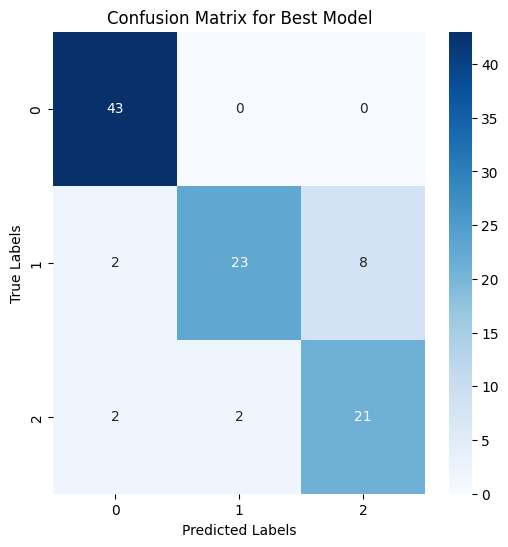

In [279]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
extractor = FeatureExtractor().to(device)
cam_model = CAM().to(device)

# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(cam_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=1e-2) # L2

best_val_acc = 0.0
best_val_auc = 0.0
best_val_f1 = 0.0
best_conf_matrix = None

for epoch in range(EPOCHS):
    cam_model.train()
    extractor.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    for images, input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        # Feature extraction
        img_feat, text_feat = extractor(images, input_ids, attention_mask)

        # CAM model forward pass
        outputs = cam_model(img_feat, text_feat)  # Multi-class outputs (logits)

        assert outputs.shape[1] == 3, f"Expected 3 classes in output, but got {outputs.shape[1]}"

        # Loss calculation
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute predictions
        _, predicted_labels = torch.max(outputs, 1)
        correct_preds += (predicted_labels == labels).sum().item()
        total_preds += labels.size(0)

        all_preds.append(torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy())  # Probabilities
        all_labels.append(labels.cpu().detach().numpy())

    train_acc = correct_preds / total_preds
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    train_f1 = f1_score(all_labels, np.argmax(all_preds, axis=1), average='macro')
    train_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr', average='macro')

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_acc:.4f}, Training F1-score: {train_f1:.4f}, Training AUC-ROC: {train_auc:.4f}")

    # ============================
    # Validation Loop
    # ============================
    cam_model.eval()
    val_correct_preds = 0
    val_total_preds = 0
    val_all_preds = []
    val_all_labels = []

    with torch.no_grad():
        for images, input_ids, attention_mask, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}"):
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Feature extraction
            img_feat, text_feat = extractor(images, input_ids, attention_mask)

            # CAM model forward pass
            outputs = cam_model(img_feat, text_feat)  # Multi-class outputs (logits)

            _, predicted_labels = torch.max(outputs, 1)
            val_correct_preds += (predicted_labels == labels).sum().item()
            val_total_preds += labels.size(0)

            val_all_preds.append(torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy())  # Probabilities
            val_all_labels.append(labels.cpu().detach().numpy())

    val_acc = val_correct_preds / val_total_preds
    val_all_preds = np.concatenate(val_all_preds, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)

    val_f1 = f1_score(val_all_labels, np.argmax(val_all_preds, axis=1), average='macro')
    val_auc = roc_auc_score(val_all_labels, val_all_preds, multi_class='ovr', average='macro')

    print(f"Epoch {epoch+1}/{EPOCHS}, Validation Accuracy: {val_acc:.4f}, Validation F1-score: {val_f1:.4f}, Validation AUC-ROC: {val_auc:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_auc = val_auc
        best_val_f1 = val_f1
        val_predictions = np.argmax(val_all_preds, axis=1)
        best_conf_matrix = confusion_matrix(val_all_labels, val_predictions)
        torch.save(cam_model.state_dict(), "best_cancer_cam_model.pth")


# ============================
# Print Final Best Statistics
# ============================
print("\nBest Model Statistics:")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation F1-score: {best_val_f1:.4f}")
print(f"Best Validation AUC-ROC: {best_val_auc:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Best Model")
plt.show()